In [1]:
# !pip install -U textblob

In [2]:
# For EDA now, will add more libraries as we progress
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
from textblob import TextBlob

# Set nice style for plots
sns.set_theme(style='darkgrid')
sns.dark_palette("#69d", reverse=True, as_cmap=True)
sns.set_context("paper")



# 1. Read Data

Our data was taken from this database of [Google Local Data 2021](https://datarepo.eng.ucsd.edu/mcauley_group/gdrive/googlelocal/#subsets). We previously used a smaller dataset of Google Restaurant reviews available [here](https://www.kaggle.com/datasets/denizbilginn/google-maps-restaurant-reviews), with only 1100 reviews, but as per our TF's recommendation, we will be using this larger dataset with over 10m reviews for Massachusetts alone. To speed up our EDA, we will be using a sample of 100,000 reviews.

<div style="background-color:#3F7FBF; color:white; padding:10px"> 

Our main dataset, stored in the `df` variable, contains 100,000 reviews. Our columns of interest are `rating`, which is the rating given by the user, `text`, which is the review text, and `gmap_id`, which is the Google Maps ID of the business. 

We also have a metadata dataset, stored in the `df_meta` variable, which contains information about each business in Massachusetts. The columns of interest are `gmap_id`, allowing us to join this dataset with the main one, `name`, which is the name of the business, and `description`, which is a brief description of the business. There is also a variable `category` that organizes the businesses into sectors such as non-profits, gyms, restaurants, etc. 

In [3]:
# Load the data
with open('data/review-Massachusetts.json', 'r') as f:
    data = f.readlines()

# Convert to dataframe
data_json_str = "[" + ','.join(data) + "]"
df = pd.read_json(StringIO(data_json_str))

In [4]:
# Examine df
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5624944 entries, 0 to 5624943
Data columns (total 8 columns):
 #   Column   Dtype  
---  ------   -----  
 0   user_id  float64
 1   name     object 
 2   time     int64  
 3   rating   int64  
 4   text     object 
 5   pics     object 
 6   resp     object 
 7   gmap_id  object 
dtypes: float64(1), int64(2), object(5)
memory usage: 343.3+ MB
None
        user_id              name           time  rating  \
0  1.180340e+20     Donna Carlson  1619732714443       5   
1  1.101673e+20   michael simmons  1615400031636       5   
2  1.122136e+20       Paul Murray  1593992657241       5   
3  1.081745e+20  Elba De Oliveira  1582074606394       5   
4  1.089901e+20      Sherri Mayne  1572962045881       5   

                                                text  pics  resp  \
0        People run it make sure you are comfortable  None  None   
1                      When you need a helping hand.  None  None   
2  Very Helpful and understanding 

In [5]:
# Also load the whole meta-Massachusetts.json file. This contains metadata about the businesses, 
# since the reviews only contain the business id.
with open('data/meta-Massachusetts.json', 'r') as f:
    data_meta = f.readlines()

data_meta_str = "[" + ','.join(data_meta) + "]"
df_meta = pd.read_json(StringIO(data_meta_str))

# Filter dataframe so that it only contains restaurants
df_meta = df_meta[df_meta['category'].apply(lambda x: isinstance(x, list) and any('restaurant' in category.lower() for category in x) if x is not None else False)]

In [6]:
# Examine df
print(df_meta.info())
print(df_meta.head())

<class 'pandas.core.frame.DataFrame'>
Index: 16079 entries, 14 to 92514
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              16079 non-null  object 
 1   address           16055 non-null  object 
 2   gmap_id           16079 non-null  object 
 3   description       9341 non-null   object 
 4   latitude          16079 non-null  float64
 5   longitude         16079 non-null  float64
 6   category          16079 non-null  object 
 7   avg_rating        16079 non-null  float64
 8   num_of_reviews    16079 non-null  int64  
 9   price             11987 non-null  object 
 10  hours             15127 non-null  object 
 11  MISC              15994 non-null  object 
 12  state             11728 non-null  object 
 13  relative_results  15090 non-null  object 
 14  url               16079 non-null  object 
dtypes: float64(3), int64(1), object(11)
memory usage: 2.0+ MB
None
                            

In [7]:
# Merging the dataframes on 'gmap_id'
# 'inner' will only include rows that have matching 'gmap_id' in both dataframes
df_combined = pd.merge(df, df_meta, on='gmap_id', how='inner')

In [8]:
# Examine the combined dataframe
print(df_combined.info())
print(df_combined.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2552669 entries, 0 to 2552668
Data columns (total 22 columns):
 #   Column            Dtype  
---  ------            -----  
 0   user_id           float64
 1   name_x            object 
 2   time              int64  
 3   rating            int64  
 4   text              object 
 5   pics              object 
 6   resp              object 
 7   gmap_id           object 
 8   name_y            object 
 9   address           object 
 10  description       object 
 11  latitude          float64
 12  longitude         float64
 13  category          object 
 14  avg_rating        float64
 15  num_of_reviews    int64  
 16  price             object 
 17  hours             object 
 18  MISC              object 
 19  state             object 
 20  relative_results  object 
 21  url               object 
dtypes: float64(4), int64(3), object(15)
memory usage: 428.5+ MB
None
        user_id             name_x           time  rating  \
0  1.053246e

<div style="background-color:#3F7FBF; color:white; padding:10px"> 

We merged the main dataset and our meta dataset based on `gmap_id` and filtered out the ones of restaurants.

We will clean up the dataframe for our purpose. From below we see that we can probably get rid of these columns: `name_x` (since we don't care about the name of the reviewer, having `user_id` is enough to identify them; `time` (for now we don't care about when the reviewers wrote the reviews); `pics` (we don't care about pictures first, but might use it in the future if time permits); `resp` (most of them are `None`); `gmap_id`(we can identify restaurants based on their names which is easier to understand); `description` (most of them are `None`); `relative_results`; `url`)

We see that there are duplicates in our merged dataset. We will drop the duplicates after we clean up the dataframe to only keep necessary columns.

In [9]:
df_combined.head()

,user_id,name_x,time,rating,text,pics,resp,gmap_id,name_y,address,...,longitude,category,avg_rating,num_of_reviews,price,hours,MISC,state,relative_results,url
0,1.053246e+20,Jessica,1515819902193,4,What a great experience. I tried the chicken t...,[{'url': ['https://lh5.googleusercontent.com/p...,None,0x89e3169821e62d4d:0x14ff0683c1ebca0e,Three Star Pizza,"Three Star Pizza, 409 Cabot St #1, Beverly, MA...",...,-70.881542,"[Pizza restaurant, Italian restaurant, Deliver...",3.9,48,$$,"[[Thursday, 11AM–8PM], [Friday, 11AM–10PM], [S...","{'Service options': ['Takeout', 'Delivery'], '...",Permanently closed,"[0x89e31418f27b6a29:0x2fd2e82a6f96214c, 0x89e3...",https://www.google.com/maps/place//data=!4m2!3...
1,1.053246e+20,Jessica,1515819902193,4,What a great experience. I tried the chicken t...,[{'url': ['https://lh5.googleusercontent.com/p...,None,0x89e3169821e62d4d:0x14ff0683c1ebca0e,Three Star Pizza,"Three Star Pizza, 409 Cabot St #1, Beverly, MA...",...,-70.881542,"[Pizza restaurant, Italian restaurant, Deliver...",3.9,48,$$,"[[Thursday, 11AM–8PM], [Friday, 11AM–10PM], [S...","{'Service options': ['Takeout', 'Delivery'], '...",Permanently closed,"[0x89e31418f27b6a29:0x2fd2e82a6f96214c, 0x89e3...",https://www.google.com/maps/place//data=!4m2!3...
2,1.085975e+20,Joey Taraborrelli,1529934471266,5,"The owner, T, is a wonderful man. Super friend...",None,None,0x89e3169821e62d4d:0x14ff0683c1ebca0e,Three Star Pizza,"Three Star Pizza, 409 Cabot St #1, Beverly, MA...",...,-70.881542,"[Pizza restaurant, Italian restaurant, Deliver...",3.9,48,$$,"[[Thursday, 11AM–8PM], [Friday, 11AM–10PM], [S...","{'Service options': ['Takeout', 'Delivery'], '...",Permanently closed,"[0x89e31418f27b6a29:0x2fd2e82a6f96214c, 0x89e3...",https://www.google.com/maps/place//data=!4m2!3...
3,1.085975e+20,Joey Taraborrelli,1529934471266,5,"The owner, T, is a wonderful man. Super friend...",None,None,0x89e3169821e62d4d:0x14ff0683c1ebca0e,Three Star Pizza,"Three Star Pizza, 409 Cabot St #1, Beverly, MA...",...,-70.881542,"[Pizza restaurant, Italian restaurant, Deliver...",3.9,48,$$,"[[Thursday, 11AM–8PM], [Friday, 11AM–10PM], [S...","{'Service options': ['Takeout', 'Delivery'], '...",Permanently closed,"[0x89e31418f27b6a29:0x2fd2e82a6f96214c, 0x89e3...",https://www.google.com/maps/place//data=!4m2!3...
4,1.118395e+20,Joseph Cannella,1499695432617,5,"Love this place, always have & always will. ...",None,None,0x89e3169821e62d4d:0x14ff0683c1ebca0e,Three Star Pizza,"Three Star Pizza, 409 Cabot St #1, Beverly, MA...",...,-70.881542,"[Pizza restaurant, Italian restaurant, Deliver...",3.9,48,$$,"[[Thursday, 11AM–8PM], [Friday, 11AM–10PM], [S...","{'Service options': ['Takeout', 'Delivery'], '...",Permanently closed,"[0x89e31418f27b6a29:0x2fd2e82a6f96214c, 0x89e3...",https://www.google.com/maps/place//data=!4m2!3...


In [11]:
df_cleaned

,user_id,rating,text,name_y,address,latitude,longitude,category,avg_rating,num_of_reviews,price,hours,MISC,state
0,1.053246e+20,4,What a great experience. I tried the chicken t...,Three Star Pizza,"Three Star Pizza, 409 Cabot St #1, Beverly, MA...",42.559072,-70.881542,"[Pizza restaurant, Italian restaurant, Deliver...",3.9,48,$$,"[[Thursday, 11AM–8PM], [Friday, 11AM–10PM], [S...","{'Service options': ['Takeout', 'Delivery'], '...",Permanently closed
1,1.053246e+20,4,What a great experience. I tried the chicken t...,Three Star Pizza,"Three Star Pizza, 409 Cabot St #1, Beverly, MA...",42.559072,-70.881542,"[Pizza restaurant, Italian restaurant, Deliver...",3.9,48,$$,"[[Thursday, 11AM–8PM], [Friday, 11AM–10PM], [S...","{'Service options': ['Takeout', 'Delivery'], '...",Permanently closed
2,1.085975e+20,5,"The owner, T, is a wonderful man. Super friend...",Three Star Pizza,"Three Star Pizza, 409 Cabot St #1, Beverly, MA...",42.559072,-70.881542,"[Pizza restaurant, Italian restaurant, Deliver...",3.9,48,$$,"[[Thursday, 11AM–8PM], [Friday, 11AM–10PM], [S...","{'Service options': ['Takeout', 'Delivery'], '...",Permanently closed
3,1.085975e+20,5,"The owner, T, is a wonderful man. Super friend...",Three Star Pizza,"Three Star Pizza, 409 Cabot St #1, Beverly, MA...",42.559072,-70.881542,"[Pizza restaurant, Italian restaurant, Deliver...",3.9,48,$$,"[[Thursday, 11AM–8PM], [Friday, 11AM–10PM], [S...","{'Service options': ['Takeout', 'Delivery'], '...",Permanently closed
4,1.118395e+20,5,"Love this place, always have & always will. ...",Three Star Pizza,"Three Star Pizza, 409 Cabot St #1, Beverly, MA...",42.559072,-70.881542,"[Pizza restaurant, Italian restaurant, Deliver...",3.9,48,$$,"[[Thursday, 11AM–8PM], [Friday, 11AM–10PM], [S...","{'Service options': ['Takeout', 'Delivery'], '...",Permanently closed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2552664,1.035690e+20,5,None,Martha's Vineyard Chowder Company,"Martha's Vineyard Chowder Company, 9 Oak Bluff...",41.457841,-70.557289,"[Seafood restaurant, American restaurant, Rest...",4.4,445,$$,"[[Thursday, Closed], [Friday, Closed], [Saturd...","{'Service options': ['Outdoor seating', 'Curbs...",NaN
2552665,1.022961e+20,5,None,Martha's Vineyard Chowder Company,"Martha's Vineyard Chowder Company, 9 Oak Bluff...",41.457841,-70.557289,"[Seafood restaurant, American restaurant, Rest...",4.4,445,$$,"[[Thursday, Closed], [Friday, Closed], [Saturd...","{'Service options': ['Outdoor seating', 'Curbs...",NaN
2552666,1.026475e+20,5,None,Martha's Vineyard Chowder Company,"Martha's Vineyard Chowder Company, 9 Oak Bluff...",41.457841,-70.557289,"[Seafood restaurant, American restaurant, Rest...",4.4,445,$$,"[[Thursday, Closed], [Friday, Closed], [Saturd...","{'Service options': ['Outdoor seating', 'Curbs...",NaN
2552667,1.099938e+20,5,None,Martha's Vineyard Chowder Company,"Martha's Vineyard Chowder Company, 9 Oak Bluff...",41.457841,-70.557289,"[Seafood restaurant, American restaurant, Rest...",4.4,445,$$,"[[Thursday, Closed], [Friday, Closed], [Saturd...","{'Service options': ['Outdoor seating', 'Curbs...",NaN


In [12]:
columns_to_drop = ['name_x', 'time', 'pics', 'resp', 'description', 'relative_results', 'url']
df_cleaned = df_combined.drop(columns=columns_to_drop)

# Drop duplicates based on `user_id` and `gmap_id` to ensure unique reviews per user per restaurant
df_cleaned = df_cleaned.drop_duplicates(subset=['user_id', 'gmap_id'])

df_cleaned.head()

,user_id,rating,text,gmap_id,name_y,address,latitude,longitude,category,avg_rating,num_of_reviews,price,hours,MISC,state
0,1.053246e+20,4,What a great experience. I tried the chicken t...,0x89e3169821e62d4d:0x14ff0683c1ebca0e,Three Star Pizza,"Three Star Pizza, 409 Cabot St #1, Beverly, MA...",42.559072,-70.881542,"[Pizza restaurant, Italian restaurant, Deliver...",3.9,48,$$,"[[Thursday, 11AM–8PM], [Friday, 11AM–10PM], [S...","{'Service options': ['Takeout', 'Delivery'], '...",Permanently closed
2,1.085975e+20,5,"The owner, T, is a wonderful man. Super friend...",0x89e3169821e62d4d:0x14ff0683c1ebca0e,Three Star Pizza,"Three Star Pizza, 409 Cabot St #1, Beverly, MA...",42.559072,-70.881542,"[Pizza restaurant, Italian restaurant, Deliver...",3.9,48,$$,"[[Thursday, 11AM–8PM], [Friday, 11AM–10PM], [S...","{'Service options': ['Takeout', 'Delivery'], '...",Permanently closed
4,1.118395e+20,5,"Love this place, always have & always will. ...",0x89e3169821e62d4d:0x14ff0683c1ebca0e,Three Star Pizza,"Three Star Pizza, 409 Cabot St #1, Beverly, MA...",42.559072,-70.881542,"[Pizza restaurant, Italian restaurant, Deliver...",3.9,48,$$,"[[Thursday, 11AM–8PM], [Friday, 11AM–10PM], [S...","{'Service options': ['Takeout', 'Delivery'], '...",Permanently closed
6,1.149863e+20,5,Awesome pizzas and subs. Their hawaiin pizza i...,0x89e3169821e62d4d:0x14ff0683c1ebca0e,Three Star Pizza,"Three Star Pizza, 409 Cabot St #1, Beverly, MA...",42.559072,-70.881542,"[Pizza restaurant, Italian restaurant, Deliver...",3.9,48,$$,"[[Thursday, 11AM–8PM], [Friday, 11AM–10PM], [S...","{'Service options': ['Takeout', 'Delivery'], '...",Permanently closed
8,1.012653e+20,1,"This was the worst experience ever, they told...",0x89e3169821e62d4d:0x14ff0683c1ebca0e,Three Star Pizza,"Three Star Pizza, 409 Cabot St #1, Beverly, MA...",42.559072,-70.881542,"[Pizza restaurant, Italian restaurant, Deliver...",3.9,48,$$,"[[Thursday, 11AM–8PM], [Friday, 11AM–10PM], [S...","{'Service options': ['Takeout', 'Delivery'], '...",Permanently closed


In [13]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2524427 entries, 0 to 2552668
Data columns (total 15 columns):
 #   Column          Dtype  
---  ------          -----  
 0   user_id         float64
 1   rating          int64  
 2   text            object 
 3   gmap_id         object 
 4   name_y          object 
 5   address         object 
 6   latitude        float64
 7   longitude       float64
 8   category        object 
 9   avg_rating      float64
 10  num_of_reviews  int64  
 11  price           object 
 12  hours           object 
 13  MISC            object 
 14  state           object 
dtypes: float64(4), int64(2), object(9)
memory usage: 308.2+ MB


<div style="background-color:#3F7FBF; color:white; padding:10px"> 

The `MISC` column contains dictionaries with useful information. We decided to further process this column and extract the attributes out as new columns of our dataframe.

In [14]:
print(df_cleaned.loc[0, 'MISC'])

{'Service options': ['Takeout', 'Delivery'], 'Accessibility': ['Wheelchair accessible entrance'], 'Offerings': ['Comfort food', 'Late-night food', 'Vegetarian options'], 'Dining options': ['Lunch', 'Dinner', 'Dessert'], 'Payments': ['Debit cards']}


In [15]:
# First, ensure all entries in 'MISC' are dictionaries; replace None with empty dictionaries
df_cleaned['MISC'] = df_cleaned['MISC'].apply(lambda x: x if isinstance(x, dict) else {})

# Convert the 'MISC' column to a DataFrame where each key in the dictionary becomes a column
misc_expanded = pd.DataFrame(df_cleaned['MISC'].tolist())

In [16]:
# Join the expanded 'MISC' DataFrame with the original 'df_cleaned', excluding the 'MISC' column
df_expanded = pd.concat([df_cleaned.drop(columns=['MISC']), misc_expanded], axis=1)

In [17]:
df_expanded.head()

,user_id,rating,text,gmap_id,name_y,address,latitude,longitude,category,avg_rating,...,Payments,Highlights,Popular for,Amenities,Atmosphere,Health & safety,Crowd,Planning,From the business,Health and safety
0,1.053246e+20,4.0,What a great experience. I tried the chicken t...,0x89e3169821e62d4d:0x14ff0683c1ebca0e,Three Star Pizza,"Three Star Pizza, 409 Cabot St #1, Beverly, MA...",42.559072,-70.881542,"[Pizza restaurant, Italian restaurant, Deliver...",3.9,...,[Debit cards],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.085975e+20,5.0,"The owner, T, is a wonderful man. Super friend...",0x89e3169821e62d4d:0x14ff0683c1ebca0e,Three Star Pizza,"Three Star Pizza, 409 Cabot St #1, Beverly, MA...",42.559072,-70.881542,"[Pizza restaurant, Italian restaurant, Deliver...",3.9,...,[Debit cards],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.118395e+20,5.0,"Love this place, always have & always will. ...",0x89e3169821e62d4d:0x14ff0683c1ebca0e,Three Star Pizza,"Three Star Pizza, 409 Cabot St #1, Beverly, MA...",42.559072,-70.881542,"[Pizza restaurant, Italian restaurant, Deliver...",3.9,...,[Debit cards],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1.149863e+20,5.0,Awesome pizzas and subs. Their hawaiin pizza i...,0x89e3169821e62d4d:0x14ff0683c1ebca0e,Three Star Pizza,"Three Star Pizza, 409 Cabot St #1, Beverly, MA...",42.559072,-70.881542,"[Pizza restaurant, Italian restaurant, Deliver...",3.9,...,[Debit cards],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1.012653e+20,1.0,"This was the worst experience ever, they told...",0x89e3169821e62d4d:0x14ff0683c1ebca0e,Three Star Pizza,"Three Star Pizza, 409 Cabot St #1, Beverly, MA...",42.559072,-70.881542,"[Pizza restaurant, Italian restaurant, Deliver...",3.9,...,[Debit cards],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
df_expanded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2552669 entries, 0 to 2328123
Data columns (total 28 columns):
 #   Column             Dtype  
---  ------             -----  
 0   user_id            float64
 1   rating             float64
 2   text               object 
 3   gmap_id            object 
 4   name_y             object 
 5   address            object 
 6   latitude           float64
 7   longitude          float64
 8   category           object 
 9   avg_rating         float64
 10  num_of_reviews     float64
 11  price              object 
 12  hours              object 
 13  state              object 
 14  Service options    object 
 15  Accessibility      object 
 16  Offerings          object 
 17  Dining options     object 
 18  Payments           object 
 19  Highlights         object 
 20  Popular for        object 
 21  Amenities          object 
 22  Atmosphere         object 
 23  Health & safety    object 
 24  Crowd              object 
 25  Planning           obje

In [19]:
columns_of_interest = [
    "Service options", "Accessibility", "Offerings", "Dining options",
    "Payments", "Highlights", "Popular for", "Amenities",
    "Atmosphere", "Health & safety", "Crowd", "Planning",
    "From the business", "Health and safety"
]

# Initialize a dictionary to hold the unique values for each column
unique_values = {}

# Iterate over each column of interest
for column in columns_of_interest:
    # Extract the column's data
    column_data = df_expanded[column]
    
    # Since the data might contain lists, we need to flatten these into a single list before finding unique values
    # We'll use a set to automatically keep only unique items
    flattened_set = set()
    for item in column_data.dropna():  # Drop NA values to avoid errors
        if isinstance(item, list):  # Check if the item is a list
            flattened_set.update(item)  # Add all items in the list to the set
        else:
            flattened_set.add(item)  # Add the item itself if it's not a list
    
    # Store the unique values for this column in our dictionary
    unique_values[column] = list(flattened_set)  # Convert the set back to a list for readability

# Or, to print the unique values for all columns of interest:
for column, values in unique_values.items():
    print(f"{column}: {values}\n")

Service options: ['Curbside pickup', 'In-store pick-up', 'Same-day delivery', 'Takeaway', 'Dine-in', 'Drive-through', 'Outdoor seating', 'In-store pickup', 'Online appointments', 'Takeout', 'In-store shopping', 'Delivery', 'No-contact delivery']

Accessibility: ['Wheelchair accessible parking lot', 'Wheelchair accessible seating', 'Wheelchair-accessible car park', 'Wheelchair accessible restroom', 'Assisted listening devices', 'Wheelchair accessible elevator', 'Wheelchair-accessible entrance', 'Wheelchair-accessible seating', 'Wheelchair rental', 'Wheelchair-accessible toilet', 'Wheelchair-accessible lift', 'Wheelchair accessible entrance']

Offerings: ['Spirits', 'Happy hour drinks', 'Ethanol-free gas', 'Salad bar', 'Food at bar', 'Car wash', 'Happy-hour food', 'Late-night food', 'Comfort food', 'Vegetarian options', 'Organic products', 'Happy-hour drinks', 'Service guarantee', 'Cocktails', 'All you can eat', 'Small plates', 'Organic dishes', 'Hard liquor', 'Prepared foods', 'Healthy 

In [20]:
# Counting NaN values in each column of df_expanded
nan_counts = df_expanded.isna().sum()

# Displaying the count of NaN values per column
print(nan_counts)

user_id                28242
rating                 28242
text                 1220681
gmap_id                28242
name_y                 28242
address                28899
latitude               28242
longitude              28242
category               28242
avg_rating             28242
num_of_reviews         28242
price                 239227
hours                  90075
state                1165444
Service options        89331
Accessibility         223478
Offerings             211734
Dining options        401109
Payments              950551
Highlights            789779
Popular for           423542
Amenities             256395
Atmosphere            373552
Health & safety      1030766
Crowd                 388729
Planning             1349060
From the business    2452245
Health and safety    2514255
dtype: int64


<div style="background-color:#3F7FBF; color:white; padding:10px"> 
Since we will focus on reviews, we decided to drop rows with `text` (which is the review column) empty. We will also drop the rows with `rating` empty.

In [21]:
# Drop rows where the 'text' column is NaN
df_expanded_clean = df_expanded.dropna(subset=['text', 'rating'])
df_expanded_clean.isna().sum()

user_id                    0
rating                     0
text                       0
gmap_id                    0
name_y                     0
address                  375
latitude                   0
longitude                  0
category                   0
avg_rating                 0
num_of_reviews             0
price                 118502
hours                  32504
state                 589361
Service options        46659
Accessibility         117034
Offerings             111042
Dining options        208545
Payments              496633
Highlights            414100
Popular for           220375
Amenities             134411
Atmosphere            195120
Health & safety       539678
Crowd                 204638
Planning              707240
From the business    1279778
Health and safety    1311619
dtype: int64

<div style="background-color:#3F7FBF; color:white; padding:10px"> 
    
Let's further inspect these columns and decide either to drop them or process them.

`Planning`, `From the business`, and `Health and safety` simply just have too many missing values, so we will drop them.

We decided to drop `address` column since we will be able to infer the address based on names of the restaurants and the latitude and longitude.

`state` describes the current states of the restraurants when the dataset authors scraped it. This is not that helpful for our analysis so we will drop this column too.

There are some other variables which are not important for our analysis for now. We will drop them as well and start thinking about how to process the rest (e.g. one-hot encode).

In [22]:
df_expanded_clean['state'].unique()

array(['Permanently closed', None,
       'Closes soon ⋅ 8:30PM ⋅ Opens 11AM Thu', 'Open ⋅ Closes 10PM',
       'Closes soon ⋅ 4PM ⋅ Opens 8AM Thu', 'Open ⋅ Closes 8PM',
       'Open ⋅ Closes 5PM', 'Closed ⋅ Opens 11AM',
       'Closed ⋅ Opens 11:30AM', 'Closed ⋅ Opens 5PM Thu',
       'Open ⋅ Closes 2AM', 'Closed ⋅ Opens 11AM Wed',
       'Closed ⋅ Opens 8AM Wed', 'Closed ⋅ Opens 8:30AM Wed',
       'Closed ⋅ Opens 7:30AM Wed', 'Closed ⋅ Opens 7:15AM',
       'Closes soon ⋅ 9PM ⋅ Opens 10AM Tue', 'Open 24 hours',
       'Closed ⋅ Opens 7AM', 'Closed ⋅ Opens 7:30AM Mon',
       'Closed ⋅ Opens 5:30AM Mon', 'Closed ⋅ Opens 11AM Mon',
       'Closed ⋅ Opens 9AM', 'Closed ⋅ Opens 12PM', 'Open ⋅ Closes 9PM',
       'Open ⋅ Closes 7PM', 'Open ⋅ Closes 4PM', 'Closed ⋅ Opens 10AM',
       'Open ⋅ Closes 11PM', 'Closed ⋅ Opens 8AM Thu',
       'Closed ⋅ Opens 10:30AM Thu', 'Open ⋅ Closes 6PM',
       'Closed ⋅ Opens 11AM Fri', 'Open ⋅ Closes 8:30PM',
       'Closes soon ⋅ 2PM ⋅ Opens 5:30AM We

In [23]:
df_expanded_clean['price'].unique()

array(['$$', None, '$', '$$$', '₩₩', '₩', '₩₩₩', '$$$$'], dtype=object)

In [29]:
df_expanded_clean['hours'].astype(str).unique()

array(["[['Thursday', '11AM–8PM'], ['Friday', '11AM–10PM'], ['Saturday', '11AM–10PM'], ['Sunday', '4–10PM'], ['Monday', 'Closed'], ['Tuesday', '11AM–8PM'], ['Wednesday', '11AM–8PM']]",
       'None',
       "[['Wednesday', '11AM–8:30PM'], ['Thursday', '11AM–8:30PM'], ['Friday', '11AM–9PM'], ['Saturday', '11AM–9PM'], ['Sunday', '11AM–8:30AM'], ['Monday', '11AM–8:30AM'], ['Tuesday', '11AM–8:30PM']]",
       ...,
       "[['Friday', '11:30AM–8PM'], ['Saturday', '4–8PM'], ['Sunday', '4–8PM'], ['Monday', '11:30AM–8PM'], ['Tuesday', '11:30AM–8PM'], ['Wednesday', '11:30AM–8PM'], ['Thursday', '11:30AM–8PM']]",
       "[['Friday', '7AM–8PM'], ['Saturday', '7AM–8PM'], ['Sunday', '11AM–8PM'], ['Monday', '7AM–8PM'], ['Tuesday', '7AM–8PM'], ['Wednesday', '7AM–8PM'], ['Thursday', '7AM–8PM']]",
       "[['Thursday', 'Closed'], ['Friday', 'Closed'], ['Saturday', 'Closed'], ['Sunday', '3:35–3:36AM'], ['Monday', 'Closed'], ['Tuesday', 'Closed'], ['Wednesday', 'Closed']]"],
      dtype=object)

In [31]:
df_expanded_clean['Service options'].astype(str).unique()

array(["['Takeout', 'Delivery']", "['Delivery']",
       "['Delivery', 'Takeout']", "['Delivery', 'Takeout', 'Dine-in']",
       "['Takeout', 'Dine-in']",
       "['In-store shopping', 'Takeout', 'Dine-in', 'Delivery']",
       "['Outdoor seating', 'Takeout', 'Dine-in', 'Delivery']",
       "['Takeout', 'Dine-in', 'Delivery']",
       "['Drive-through', 'Takeout', 'Dine-in', 'Delivery']",
       "['Curbside pickup', 'In-store pickup', 'In-store shopping', 'Takeout', 'Dine-in', 'Delivery']",
       "['Curbside pickup', 'In-store pickup', 'In-store shopping', 'Takeout', 'Delivery']",
       "['No-contact delivery', 'Delivery', 'Takeout', 'Dine-in']", 'nan',
       "['Outdoor seating', 'Delivery', 'Takeout', 'Dine-in']",
       "['Curbside pickup', 'No-contact delivery', 'Delivery', 'Takeout', 'Dine-in']",
       "['Outdoor seating', 'Curbside pickup', 'No-contact delivery', 'Delivery', 'Takeout', 'Dine-in']",
       "['Takeout']", "['Takeout', 'Delivery', 'Dine-in']",
       "['Curbside 

In [32]:
df_expanded_clean['Accessibility'].astype(str).unique()

array(["['Wheelchair accessible entrance']",
       "['Wheelchair accessible entrance', 'Wheelchair accessible restroom']",
       "['Wheelchair accessible entrance', 'Wheelchair accessible seating']",
       'nan', "['Wheelchair accessible elevator']",
       "['Wheelchair accessible entrance', 'Wheelchair accessible restroom', 'Wheelchair accessible seating']",
       "['Wheelchair accessible entrance', 'Wheelchair accessible parking lot', 'Wheelchair accessible restroom', 'Wheelchair accessible seating']",
       "['Wheelchair accessible entrance', 'Wheelchair accessible parking lot', 'Wheelchair accessible restroom']",
       "['Wheelchair accessible parking lot', 'Wheelchair accessible seating']",
       "['Wheelchair accessible entrance', 'Wheelchair accessible parking lot', 'Wheelchair accessible seating']",
       "['Wheelchair accessible elevator', 'Wheelchair accessible entrance', 'Wheelchair accessible parking lot']",
       "['Wheelchair accessible parking lot']",
       "[

In [ ]:
df_expanded_clean['Offerings'].astype(str).unique()

array(["['Comfort food', 'Late-night food', 'Vegetarian options']",
       "['Coffee', 'Comfort food', 'Healthy options', 'Organic dishes', 'Quick bite', 'Vegetarian options']",
       "['Coffee', 'Comfort food', 'Healthy options', 'Quick bite', 'Small plates', 'Vegetarian options']",
       ...,
       '[\'Alcohol\', \'All you can eat\', \'Beer\', \'Braille menu\', \'Cocktails\', \'Coffee\', \'Comfort food\', \'Happy hour drinks\', \'Happy hour food\', \'Hard liquor\', "Kids\' menu", \'Late-night food\', \'Organic dishes\', \'Small plates\', \'Vegetarian options\', \'Wine\']',
       '[\'Alcohol\', \'Coffee\', \'Comfort food\', \'Food\', \'Food at bar\', \'Happy hour food\', "Kids\' menu", \'Late-night food\', \'Quick bite\']',
       '[\'Coffee\', \'Halal food\', \'Healthy options\', "Kids\' menu", \'Late-night food\', \'Quick bite\', \'Vegetarian options\']'],
      dtype=object)

In [ ]:
df_expanded_clean['Dining options'].astype(str).unique()

array(["['Lunch', 'Dinner', 'Dessert']",
       "['Breakfast', 'Lunch', 'Dinner', 'Dessert']", "['Dessert']", nan,
       "['Breakfast', 'Lunch', 'Catering', 'Dessert', 'Seating']",
       "['Lunch', 'Dinner', 'Catering', 'Dessert', 'Seating']",
       "['Breakfast', 'Lunch', 'Dinner', 'Dessert', 'Seating']",
       "['Breakfast']", "['Breakfast', 'Lunch', 'Dessert']",
       "['Breakfast', 'Dessert']",
       "['Lunch', 'Dinner', 'Catering', 'Dessert']",
       "['Breakfast', 'Lunch', 'Dinner']", "['Seating']",
       "['Lunch', 'Dinner', 'Seating']",
       "['Breakfast', 'Lunch', 'Dinner', 'Catering', 'Dessert', 'Seating']",
       "['Lunch', 'Dinner']", "['Breakfast', 'Lunch']",
       "['Breakfast', 'Lunch', 'Dinner', 'Counter service', 'Dessert']",
       "['Lunch', 'Dinner', 'Catering']", "['Lunch', 'Catering']",
       "['Lunch', 'Dinner', 'Dessert', 'Seating']",
       "['Lunch', 'Catering', 'Dessert']",
       "['Lunch', 'Dinner', 'Catering', 'Seating']", "['Dinner']",
      

In [ ]:
df_expanded_clean['Payments'].astype(str).unique()

array(["['Debit cards']", nan, "['NFC mobile payments']",
       "['Debit cards', 'Credit cards']",
       "['Debit cards', 'NFC mobile payments', 'Credit cards']",
       "['Debit cards', 'NFC mobile payments']",
       "['Checks', 'Debit cards', 'Credit cards']", "['Credit cards']",
       "['Cash-only']", "['Cash-only', 'Debit cards']",
       "['Cash-only', 'Credit cards']",
       "['Cash-only', 'Debit cards', 'Credit cards']",
       "['Cash-only', 'Checks', 'Debit cards', 'NFC mobile payments']",
       "['Cash-only', 'Checks', 'Debit cards', 'Credit cards']",
       "['NFC mobile payments', 'Credit cards']",
       "['Checks', 'Debit cards']",
       "['Checks', 'Debit cards', 'NFC mobile payments']",
       "['Cash-only', 'NFC mobile payments']", "['Checks']",
       "['Cash-only', 'Debit cards', 'NFC mobile payments']",
       "['Checks', 'Debit cards', 'NFC mobile payments', 'Credit cards']",
       "['Cash-only', 'Debit cards', 'NFC mobile payments', 'Credit cards']",
     

In [ ]:
df_expanded_clean['Highlights'].astype(str).unique()

array([nan, "['Great coffee', 'Great dessert', 'Great tea selection']",
       "['Great coffee']", "['Fast service']",
       "['Great beer selection', 'Great cocktails']",
       "['Fast service', 'Great coffee', 'Great tea selection']",
       "['Great coffee', 'Great dessert']", "['Great dessert']",
       "['LGBTQ friendly', 'Transgender safespace']",
       "['Fast service', 'Great coffee']", "['LGBTQ friendly']",
       "['Fireplace', 'Great coffee']",
       "['Great beer selection', 'Great cocktails', 'LGBTQ friendly']",
       "['Great coffee', 'Great wine list']", "['Great cocktails']",
       "['Fireplace', 'Live music']",
       "['Great beer selection', 'Great cocktails', 'Great wine list']",
       "['Live music']", "['Great dessert', 'LGBTQ friendly']",
       "['Great cocktails', 'Live music']",
       "['Fast service', 'Great beer selection', 'Great coffee', 'Great dessert', 'Great wine list']",
       "['Great cocktails', 'Great wine list']",
       "['Great beer sele

In [ ]:
df_expanded_clean['Popular for'].astype(str).unique()

array([nan, "['Breakfast', 'Lunch', 'Dinner', 'Solo dining']",
       "['Lunch', 'Dinner', 'Solo dining']",
       "['Breakfast', 'Lunch', 'Solo dining']", "['Solo dining']",
       "['Dinner', 'Solo dining']", "['Lunch', 'Solo dining']",
       "['Breakfast', 'Solo dining']", "['Lunch', 'Dinner']",
       "['Breakfast', 'Dinner', 'Solo dining']",
       "['Breakfast', 'Lunch', 'Dinner']", "['Lunch']",
       "['Breakfast', 'Lunch']", "['Breakfast']", "['Dinner']",
       "['Breakfast', 'Solo dining', 'Good for working on laptop']",
       "['Breakfast', 'Lunch', 'Solo dining', 'Good for working on laptop']",
       "['Breakfast', 'Lunch', 'Dinner', 'Solo dining', 'Good for working on laptop']",
       "['Solo dining', 'Good for working on laptop']",
       "['Lunch', 'Dinner', 'Solo dining', 'Good for working on laptop']",
       "['Lunch', 'Solo dining', 'Good for working on laptop']"],
      dtype=object)

In [ ]:
df_expanded_clean['Amenities'].unique()

array([nan, "['Good for kids', 'Restroom']", "['Good for kids']",
       "['Good for kids', 'High chairs', 'Restroom', 'Wi-Fi']",
       "['Gender-neutral restroom', 'Good for kids', 'Restroom']",
       "['Good for kids', 'High chairs']", "['Bar onsite', 'Restroom']",
       "['Good for kids', 'Restroom', 'Wi-Fi']",
       "['Bar onsite', 'Good for kids', 'High chairs']",
       "['Restroom', 'Wi-Fi']", "['Bar onsite']",
       "['Good for kids', 'High chairs', 'Restroom']",
       "['Public restroom', 'Restroom']",
       "['Gender-neutral restroom', 'Good for kids']",
       "['Bar onsite', 'Good for kids']",
       "['Good for kids', 'High chairs', 'Wi-Fi']",
       "['Bar onsite', 'High chairs', 'Restroom', 'Wi-Fi']", "['Wi-Fi']",
       "['Good for kids', 'Wi-Fi']",
       "['Gender-neutral restroom', 'Good for kids', 'High chairs', 'Restroom']",
       "['Bar onsite', 'High chairs']",
       "['Gender-neutral restroom', 'Good for kids', 'High chairs', 'Wi-Fi']",
       "['Bar on

In [ ]:
df_expanded_clean['Atmosphere'].astype(str).unique()

array([nan, "['Casual', 'Cozy']", "['Casual']",
       "['Casual', 'Cozy', 'Quiet']", "['Cozy']",
       "['Casual', 'Romantic']", "['Casual', 'Historic']",
       "['Casual', 'Trending']", "['Trending']", "['Casual', 'Quiet']",
       "['Cozy', 'Romantic']", "['Quiet', 'Romantic']", "['Romantic']",
       "['Cozy', 'Historic']", "['Casual', 'Cozy', 'Romantic']",
       "['Cozy', 'Romantic', 'Upscale']", "['Upscale']",
       "['Romantic', 'Upscale']", "['Casual', 'Cozy', 'Upscale']",
       "['Casual', 'Cozy', 'Historic']", "['Casual', 'Cosy']",
       "['Cosy', 'Romantic', 'Upmarket']",
       "['Cosy', 'Historic', 'Romantic', 'Upmarket']",
       "['Casual', 'Cozy', 'Trending']",
       "['Casual', 'Cozy', 'Romantic', 'Upscale']",
       "['Casual', 'Cosy', 'Historic']", "['Romantic', 'Upmarket']",
       "['Casual', 'Romantic', 'Trending', 'Upscale']",
       "['Casual', 'Cosy', 'Upmarket']",
       "['Cozy', 'Historic', 'Romantic', 'Upscale']",
       "['Casual', 'Cozy', 'Historic

In [ ]:
df_expanded_clean['Crowd'].astype(str).unique()

array([nan, "['Groups', 'Tourists']", "['Family-friendly']",
       "['College students', 'Family-friendly']", "['Groups', 'Locals']",
       "['College students', 'Groups']", "['Groups']",
       "['College students', 'Family-friendly', 'Tourists']",
       "['Tourists']", "['Locals']", "['Family-friendly', 'Groups']",
       "['Family-friendly', 'Tourists']", "['College students']",
       "['Family-friendly', 'Groups', 'Tourists']",
       "['Groups', 'Locals', 'Tourists']",
       "['College students', 'Tourists']",
       "['College students', 'Groups', 'Tourists']",
       "['College students', 'Family-friendly', 'Groups']",
       "['College students', 'Locals', 'Tourists']",
       "['College students', 'Groups', 'Locals']",
       "['Locals', 'Tourists']", "['College students', 'Locals']",
       "['Groups', 'Tourists', 'University students']",
       "['Family friendly', 'Tourists', 'University students']",
       "['Family friendly', 'Groups', 'Tourists', 'University student

In [33]:
columns_to_drop = ['state', 'address', 'hours', 'Service options', 'Accessibility', 'Offerings', 'Highlights', 'From the business', 'Health and safety', 'Health & safety', 'Planning', 'Payments', 'Amenities']
df_processed = df_expanded_clean.drop(columns=columns_to_drop)

In [34]:
df_processed.isna().sum()

user_id                0
rating                 0
text                   0
gmap_id                0
name_y                 0
latitude               0
longitude              0
category               0
avg_rating             0
num_of_reviews         0
price             118502
Dining options    208545
Popular for       220375
Atmosphere        195120
Crowd             204638
dtype: int64

<div style="background-color:#3F7FBF; color:white; padding:10px"> 

Since our dataset is large enough, for the remaining missing values, we decided to just simple drop the rows with missing `Popular for`, `Dining options`, and `price`.

In [35]:
df_processed2 = df_processed.dropna(subset=['Popular for', 'Dining options', 'price'])
df_processed2.isna().sum()

user_id               0
rating                0
text                  0
gmap_id               0
name_y                0
latitude              0
longitude             0
category              0
avg_rating            0
num_of_reviews        0
price                 0
Dining options        0
Popular for           0
Atmosphere          370
Crowd             22562
dtype: int64

<div style="background-color:#3F7FBF; color:white; padding:10px"> 

We can encode the missing values in `Atmosphere` as 'unknown', and the ones in `Crowd` as 'any'.

We will also need to process the representating of `price`. We decided to encode the `$` symbols as numbers, so `$` = 1, `$$` = 2, an so on.


In [36]:
# Replace NA values in 'Atmosphere' column with 'unknown'
df_processed2.loc[:, 'Atmosphere'] = df_processed2['Atmosphere'].fillna('unknown')

# Replace NA values in 'Crowd' column with 'any'
df_processed2.loc[:, 'Crowd'] = df_processed2['Crowd'].fillna('any')

In [37]:
df_processed2.isna().sum()

user_id           0
rating            0
text              0
gmap_id           0
name_y            0
latitude          0
longitude         0
category          0
avg_rating        0
num_of_reviews    0
price             0
Dining options    0
Popular for       0
Atmosphere        0
Crowd             0
dtype: int64

In [38]:
def encode_price(price):
    if pd.isna(price):
        return None  # Use np.nan 
    price = price.replace('₩', '$')  # Normalize '₩' to '$'
    return len(price)  # The number of '$' symbols corresponds to the price level


In [39]:
df_processed2.loc[:, 'price'] = df_processed2['price'].apply(encode_price)

In [40]:
df_processed2.head()

,user_id,rating,text,gmap_id,name_y,latitude,longitude,category,avg_rating,num_of_reviews,price,Dining options,Popular for,Atmosphere,Crowd
20,1.091166e+20,3.0,It's alright,0x89e3169821e62d4d:0x14ff0683c1ebca0e,Three Star Pizza,42.559072,-70.881542,"[Pizza restaurant, Italian restaurant, Deliver...",3.9,48.0,2,"[Breakfast, Lunch, Dinner, Dessert]","[Breakfast, Lunch, Dinner, Solo dining]","[Casual, Cozy]",any
22,1.103553e+20,3.0,it was hard and yucky,0x89e3169821e62d4d:0x14ff0683c1ebca0e,Three Star Pizza,42.559072,-70.881542,"[Pizza restaurant, Italian restaurant, Deliver...",3.9,48.0,2,"[Breakfast, Lunch, Dinner, Dessert]","[Breakfast, Lunch, Dinner, Solo dining]","[Casual, Cozy]",any
142,1.172942e+20,5.0,Had a small lunch here and didn't have one pro...,0x89e37bae6173982b:0x2b2156422703d5cb,Mi Casa Tu Casa,42.308251,-71.058650,"[Latin American restaurant, Guatemalan restaur...",4.5,28.0,1,"[Lunch, Dinner, Dessert, Seating]","[Lunch, Dinner, Solo dining]",[Casual],"[Family-friendly, Groups, Tourists]"
144,1.035610e+20,5.0,small place with Good food and price.,0x89e37bae6173982b:0x2b2156422703d5cb,Mi Casa Tu Casa,42.308251,-71.058650,"[Latin American restaurant, Guatemalan restaur...",4.5,28.0,1,"[Lunch, Dinner, Dessert, Seating]","[Lunch, Dinner, Solo dining]",[Casual],"[Family-friendly, Groups, Tourists]"
146,1.033256e+20,5.0,I love their pupusas. They are now la parilla,0x89e37bae6173982b:0x2b2156422703d5cb,Mi Casa Tu Casa,42.308251,-71.058650,"[Latin American restaurant, Guatemalan restaur...",4.5,28.0,1,"[Lunch, Dinner, Dessert, Seating]","[Lunch, Dinner, Solo dining]",[Casual],"[Family-friendly, Groups, Tourists]"


In [44]:
df_processed2.to_csv('data/cleaned_data.csv')

In [45]:
df_final = pd.read_csv('data/cleaned_data.csv')

# 2. EDA

In [47]:
df = df_final

## Exploring the distribution of ratings

<div style="background-color:#3F7FBF; color:white; padding:10px"> 

* Ratings are on a 1 to 5 scale.
* The majority of reviews are positive, with over 700k reviews with a rating of 4 or 5. There is also a slight spike in the number of 1 star reviews than 2 star reviews, suggesting that users who view a restaurant badly are more likely to rate the most extreme rating of 1 star.

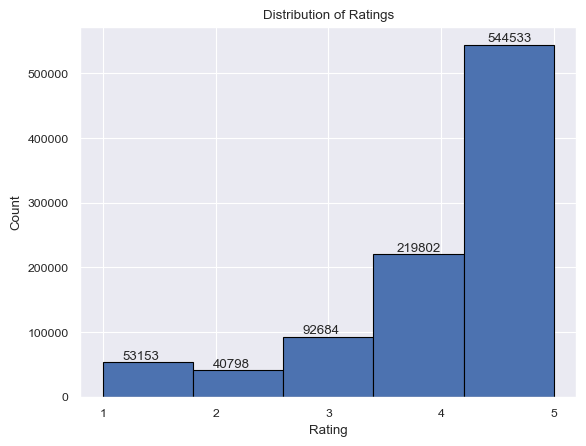

In [48]:
# Distribution of ratings: To understand the overall sentiment towards the businesses.

plt.hist(df['rating'], bins = 5, edgecolor = 'black')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
# show exact counts
for i in range(1, 6):
    plt.text(i + 0.5 if i == 1 else i + 0.3 if i == 2 else i + 0.1 if i == 3 else i if i == 4 else i - 0.2, len(df[df['rating'] == i]), str(len(df[df['rating'] == i])), ha='right', va='bottom')
# change x ticks to read 1, 2, 3, 4, 5
plt.xticks(np.arange(1, 6, 1))

plt.show()


## Exploring review counts per local business

<div style="background-color:#3F7FBF; color:white; padding:10px"> 

* Most restaurants have 0-100 reviews.
* The mean number of reviews is around 100, and the standard deviation is also around 100.
* A small number of businesses might be overrepresented in our dataset, especially the few outliers with over 600 reviews.

Summary statistics for count of reviews per business:
count    9657.000000
mean       98.474682
std       103.101616
min         1.000000
25%        32.000000
50%        66.000000
75%       128.000000
max      1319.000000
Name: count, dtype: float64


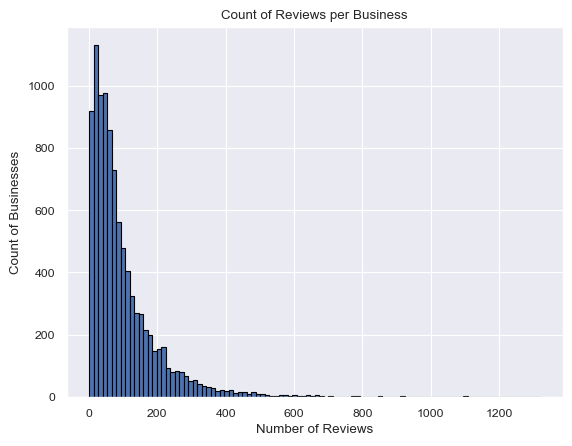

In [49]:
# Count of reviews per business - To see which businesses have been reviewed the most.

# describe the count of reviews per business
print("Summary statistics for count of reviews per business:")
print(df['gmap_id'].value_counts().describe())

df['gmap_id'].value_counts().plot(kind='hist', bins=100, edgecolor='black')
plt.title('Count of Reviews per Business')
plt.xlabel('Number of Reviews')
plt.ylabel('Count of Businesses')
plt.show()




## Exploring review lengths (in terms of number of characters)

<div style="background-color:#3F7FBF; color:white; padding:10px"> 

* We see that review lengths are distributed similarly to business ratings, with a large number of reviews having a smaller number of characters, and with the number of reviews decreasing at a decreasing rate as the review length increases.
* The mean review length is around 115, but with a large standard deviation of around 168.
* We also see outliers, especially the review with 8973 characters.

Summary statistics for review length:
count    950970.000000
mean        114.726520
std         168.111991
min           0.000000
25%          29.000000
50%          60.000000
75%         132.000000
max        8973.000000
Name: review_length, dtype: float64


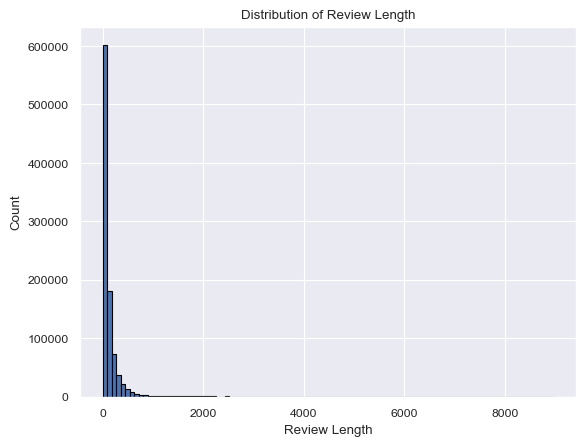

In [55]:
# Review length analysis: To see the distribution of the length of the review texts.

df['review_length'] = df['text'].apply(lambda x: len(x) if x and isinstance(x, str) else 0)

# describe the review length
print("Summary statistics for review length:")
print(df['review_length'].describe())

plt.hist(df['review_length'], bins=100, edgecolor='black')
plt.title('Distribution of Review Length')
plt.xlabel('Review Length')
plt.ylabel('Count')
plt.show()



## Exploring correlation between review length and rating

<div style="background-color:#3F7FBF; color:white; padding:10px"> 

* We analyzed the correlation between the length of the review text and the rating. The correlation coefficient is around -0.189, which suggests that there is only a weak negative correlation between the length of the review and the rating.
* This result is consistent with our intuition, as the length of a review does not necessarily indicate its quality or sentiment.
* However, perhaps some angrier customers might leave longer reviews, which could explain the slight negative correlation. 


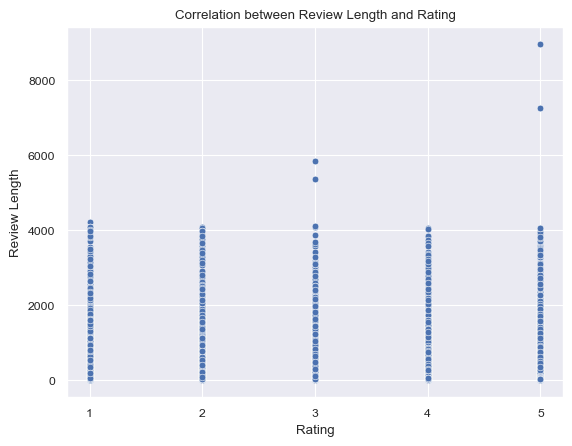

Correlation matrix:
                 rating  review_length
rating         1.000000      -0.189299
review_length -0.189299       1.000000


In [56]:
# Correlation between review length and rating: To see if there is a correlation between the length of the review and the rating given.

# plot the correlation between review length and rating
sns.scatterplot(x='rating', y='review_length', data=df)
plt.title('Correlation between Review Length and Rating')
plt.xlabel('Rating')
plt.ylabel('Review Length')
plt.xticks(np.arange(1, 6, 1))
plt.show()

correlation_matrix = df[['rating', 'review_length']].corr()
print("Correlation matrix:")
print(correlation_matrix)

## Number of unique authors

<div style="background-color:#3F7FBF; color:white; padding:10px"> 

* We see that we have 155583 unique authors for our 950,970 reviews, suggesting that most authors leave more than one review.
* This is confirmed by the mean number of reviews per author, which is around 6.1 with a standard deviation of 7.6.
* The shape of the distribution is once again similar to the previous two, with the number of authors decreasing at a decreasing rate as the number of reviews per author increases.

In [61]:
# total reviews
total_reviews = len(df)
total_reviews

950970

Number of unique authors:  155583
Summary statistics for number of ratings per author:
count    155583.000000
mean          6.112300
std           7.601384
min           1.000000
25%           2.000000
50%           4.000000
75%           7.000000
max         257.000000
Name: count, dtype: float64


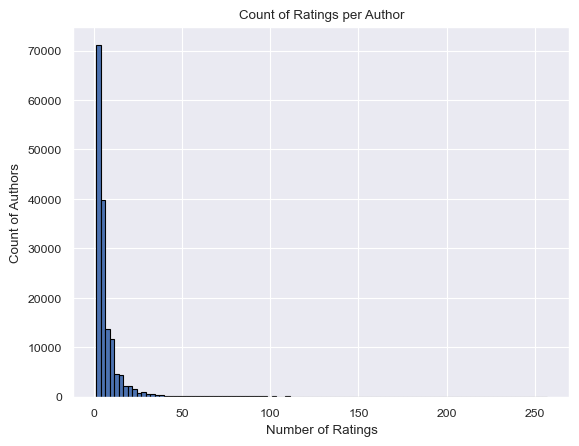

In [59]:
# How many unique authors?

print("Number of unique authors: ", df['user_id'].nunique())

# describe the count of ratings per author
print("Summary statistics for number of ratings per author:")
print(df['user_id'].value_counts().describe())

df['user_id'].value_counts().plot(kind='hist', bins=100, edgecolor='black')
plt.title('Count of Ratings per Author')
plt.xlabel('Number of Ratings')
plt.ylabel('Count of Authors')
plt.show()


## Simple sentiment analysis - Baseline Model

<div style="background-color:#3F7FBF; color:white; padding:10px"> 

* We used the `TextBlob` library to perform a simple sentiment analysis on the review text.
* First, we dropped reviews with no text, as they would not provide any information for sentiment analysis.
* We then calculated the polarity of each review, which ranges from -1 (most negative) to 1 (most positive).
* Plotting a histogram and summary statistics, we see that most reviews are moderately positive with a mean polarity of 0.42 and a standard deviation of 0.36. This is consistent with our earlier observation that most ratings are positive (5 stars).
* The distribution is roughly bell-shaped, but with a density spike at 0 and a few more spikes above 0.5. 


Summary statistics for sentiment:
count    950960.000000
mean          0.419850
std           0.356284
min          -1.000000
25%           0.197222
50%           0.450000
75%           0.700000
max           1.000000
Name: sentiment, dtype: float64


/var/folders/d8/kwvs0tzd5t7dkrqj0r00cjzr0000gn/T/ipykernel_21468/3980335880.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dropped['sentiment'] = df_dropped['text'].apply(lambda x: TextBlob(x).sentiment.polarity)


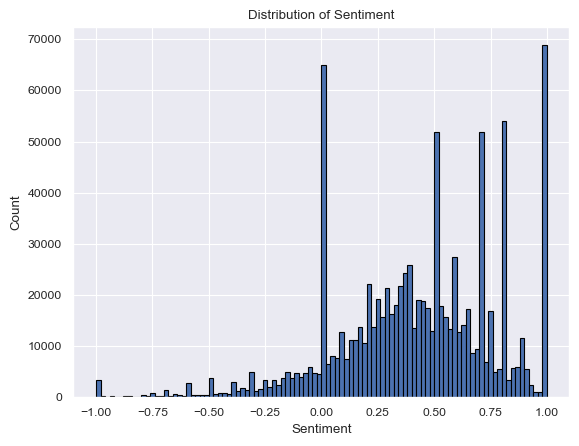

In [62]:
# Simple sentiment analysis on review text

# Add a column to the dataframe with the sentiment of the review
df_dropped = df.dropna(subset=['text'])
df_dropped['sentiment'] = df_dropped['text'].apply(lambda x: TextBlob(x).sentiment.polarity)

# print summary statistics
print("Summary statistics for sentiment:")
print(df_dropped['sentiment'].describe())

# plot the distribution of sentiment
plt.hist(df_dropped['sentiment'], bins=100, edgecolor='black')
plt.title('Distribution of Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

<div style="background-color:#3F7FBF; color:white; padding:10px"> 

There is a moderate positive correlation between sentiment score and rating, with a correlation coefficient of 0.54. This suggests that reviews with higher ratings tend to have more positive sentiment scores, which is expected. This is a good result for our training data.

We were worried that meaningful sentiment might not be extracted from short reviews, but the correlation suggests that the sentiment analysis is capturing the sentiment of the reviews decently well. Yay!

In [63]:
# Find correlation between sentiment and rating
correlation_matrix = df_dropped[['rating', 'sentiment']].corr()
print("Correlation matrix:")
print(correlation_matrix)

Correlation matrix:
            rating  sentiment
rating     1.00000    0.54039
sentiment  0.54039    1.00000


## Summary of findings

<div style="background-color:#3F7FBF; color:white; padding:10px"> 

* We see that the majority of ratings given by Google users are 5 out of 5. This aligns with the Google text review sentiment analysis, which found that the majority of the reviews had a postive sentiment.
* We also found that there is a weak correlation between the length of a text review and the rating given by the same Google user. However, it could be helpful to note that based on the visualization displayed above, the review length was longest for either 1 or 5 star reviews.
* In the sentiment analysis, we found that majority of the text reviews result in a sentiment score near 0, which suggests that many reviews are neutral. The second most common sentiment scores are those near 1, which suggests that there are also many (but not as many) reviews that are highly positive. 
* This summarizes the distributional features of our reviews in their length, sentiment and the related score.

## Revised Project Question

<div style="background-color:#3F7FBF; color:white; padding:10px"> 

Creating a restaurant recommendation system based on textual reviews and and user-inputted prompts.


## Implementation Plan -- Draft Pipeline

<div style="background-color:#3F7FBF; color:white; padding:10px"> 

The structure of our problem is similar to that of designing a recommender system. We describe an initial approach that comes to mind:

**Recommender Model Pipeline:**
- **Training step** (preprocessing): Embed the reviews for all restaurants as vectors using sentence embeddings (BERT), or a combined approach using BERT and other feature engineered features from the restaurant information that we have. One approach is then to cluster restaurants in an unsupervised way in the feature space using an approach like KNN or t-SNE. Perhaps we can do this in an informed way, however.
- **Interaction step:** Then, we may take a user prompt of sentence length describing the restaurant type they are looking for, and use the fine-tuned BERT pipeline to get a vector representation of the prompt.
- **Matching step:** Then we can take the top recommendations as the closest three or so restaurants in the feature space to the prompt. We can incorporate additional heuristics in this matching step.
  

**Potential Issues:**
- Reviews and prompts are semantically different. We might encounter unexpected relationships between the restaurants closest in the feature space based on reviews and the inputted prompts.
- Perhaps a content-based filtering approach is more directly applicable as a pipeline (ref: https://developers.google.com/machine-learning/recommendation/content-based/basics).
- With an unsupervised approach like this, we have no systematized way to measure whether our recommending algorithm is doing a good job at matching prompts to restaurants. But this is the nature of trying a recommendation system rather than a predictive model. We do not have the resources to conduct proper A/B testing, which would otherwise be a canonical solution.
-  A collaborative filtering approach would be great, but is infeasible since we cannot recruit enough users. 